# Определение возраста покупателей

## Аннотация

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя.

## Задача

- построить модель, которая по фотографии определит приблизительный возраст человека
- провести исследовательский анадиз данных (набора фотографий)
- подготовить данные к обучению
- обучить нейронную сеть и рассчитать её качество

Примечение: значения MAE на тестовой выборке не должно превышать 8

## Исследовательский анализ данных

In [1]:
#загрузим все необходимые библиотеки
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [2]:
# загрузим наш датафрейм
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


In [3]:
#выведем на экран первые 5 строк набора данных
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [4]:
#посмотрим размер датасета
labels.shape

(7591, 2)

In [5]:
#изучим общую информацию о датафрейме
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Построим график распределения возраста в выборке

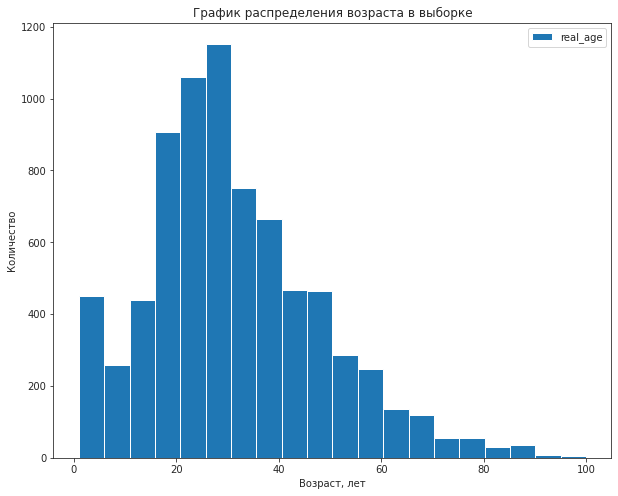

In [6]:
sns.set_style("ticks")
labels.plot(kind='hist',figsize=(10,8),bins=20, grid=False)
plt.title('График распределения возраста в выборке')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество')
plt.show()

Выведем на экран данные о 15 фотографиях

In [7]:
labels.head(15)

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
5,000005.jpg,27
6,000006.jpg,24
7,000007.jpg,43
8,000008.jpg,26
9,000009.jpg,39


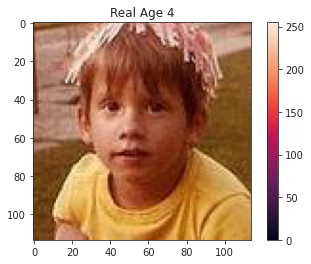

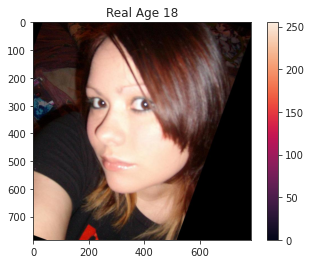

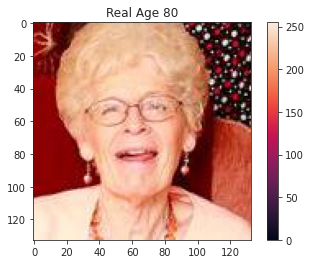

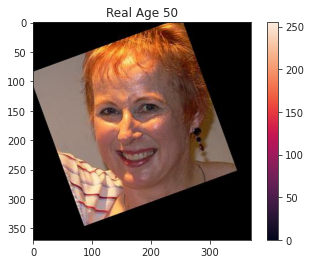

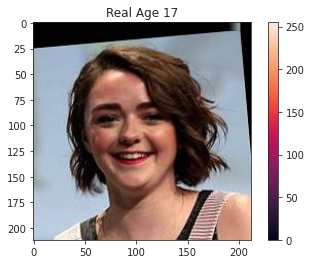

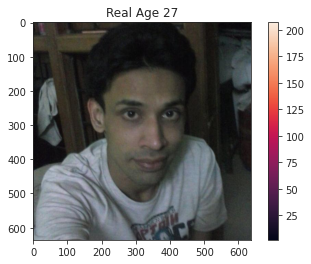

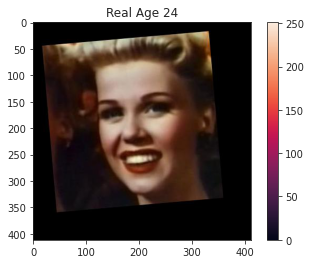

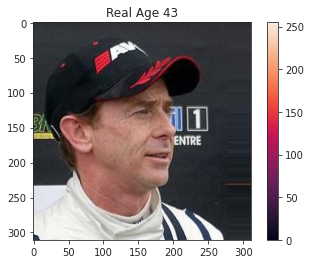

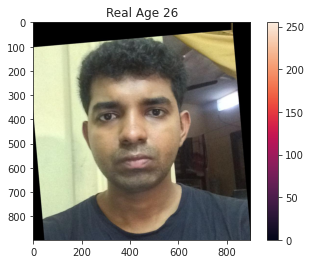

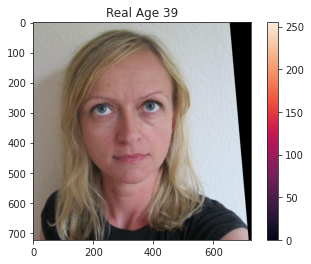

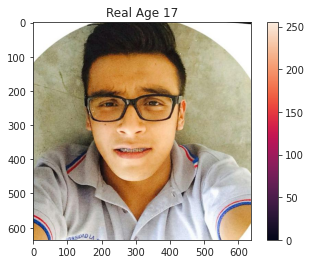

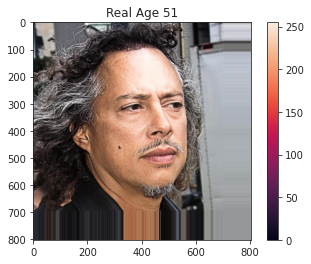

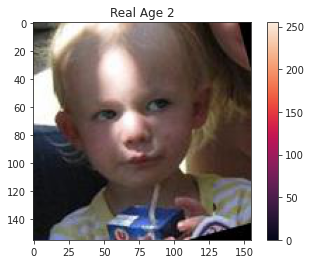

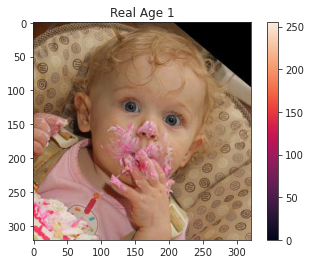

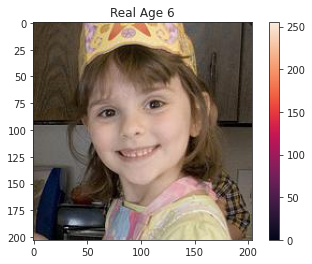

In [8]:
for i,k in zip(labels.file_name[:15],labels.real_age[:15]):
    image = Image.open('/datasets/faces/final_files/'+i)
    array = np.array(image)
    plt.imshow(array)
    plt.title('Real Age {:.0f}'.format(k))
    plt.colorbar()
    plt.show()

In [9]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


### Выводы

В нашем распоряжении датафрейм с 7591 фотографий, размер 224 на 224. Гистограмма распределения возраста выглядит нормальной со смещением вправо. Средний возраст 31 год, минимальный 1, максимальный 100. Наибольшее количество фотографий от людей возрастом от 20 до 41 лет, возможно, это связано с тем, что как раз в этот промежуток лет люди ведут самый активный образ жизни и часто фотографируются. Многие фотографии имеют нечеткое качество, другие выполнены с недостаточной яркостью, это необходимо учесть при выполнении обучения модели. Поскольку боьшинство фотографий сделано с людьми в возрасте от 20 до 41 года, именно на этом промежутке, модель будет давать более точные результаты.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import pandas as pd

def load_test(path):
    labels = pd.read_csv(path+'labels.csv') 
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345) 
    return test_datagen_flow
def load_train(path):
    labels = pd.read_csv(path+'labels.csv') 
    train_datagen = ImageDataGenerator(rescale=1./255,
                                   validation_split=0.25,
                                   horizontal_flip=True,
                                   brightness_range=(0.8, 1.))
 
    train_datagen_flow = train_datagen.flow_from_dataframe(dataframe=labels,
      directory=path + 'final_files/',
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=32,
      class_mode='raw',
      subset='training',
      seed=12345)
    return train_datagen_flow
 
 
def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape,
                    weights='imagenet', 
                    include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D()) 
    model.add(Dense(1, activation='relu')) 
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer,loss='mean_squared_error',metrics=['mae'])
    
    return model
 
def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model
```

Результат работы модели:

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
2024-12-22 08:51:41.780639: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-12-22 08:51:42.438264: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 87s - loss: 228.6220 - mae: 11.4482 - val_loss: 283.1177 - val_mae: 13.1673
Epoch 2/10
178/178 - 63s - loss: 152.1483 - mae: 9.4467 - val_loss: 285.7421 - val_mae: 13.3918
Epoch 3/10
178/178 - 63s - loss: 123.1619 - mae: 8.5496 - val_loss: 297.4881 - val_mae: 12.9235
Epoch 4/10
178/178 - 63s - loss: 108.4942 - mae: 7.9205 - val_loss: 242.3472 - val_mae: 11.7121
Epoch 5/10
178/178 - 64s - loss: 99.0591 - mae: 7.6177 - val_loss: 145.4923 - val_mae: 9.2925
Epoch 6/10
178/178 - 62s - loss: 82.0080 - mae: 6.9223 - val_loss: 158.1027 - val_mae: 9.3845
Epoch 7/10
178/178 - 65s - loss: 74.5087 - mae: 6.6419 - val_loss: 113.8944 - val_mae: 8.2169
Epoch 8/10
178/178 - 66s - loss: 61.3004 - mae: 6.0418 - val_loss: 123.0358 - val_mae: 8.5601
Epoch 9/10
178/178 - 65s - loss: 54.2069 - mae: 5.6576 - val_loss: 117.8100 - val_mae: 8.4465
Epoch 10/10
178/178 - 64s - loss: 47.2186 - mae: 5.2874 - val_loss: 89.6569 - val_mae: 7.1686
```

Модель в среднем ошибается на 7.1 лет

## Анализ обученной модели

Перед нами стояла задача построения и обучения сверточной нейронной сети на датасете с фотографиями людей со средним абсолютным отклонением MAE на тестовой выборке не больше 8. Моя модель ошибается в среднем на 7.1 лет, что удовлетворяет условиям задачи. В ходе работы использовали загрузчик данных ImageDataGenerator для загрузки большого количества данных (фотографий) в количестве 7591. В проекте использовали предобученную нейросеть с архитектурой ResNet50, с оптимизатором Adam. Значение шага обучения lr=0.001, количество эпох 10. Для увеличения скорости обучения использовал mean_squared_error. Теоритически, мы можем улучшить показатели метрики MAE, увеличив количество эпох и/или уменьшить значение шага обучения lr (к примеру 0.0001), но с нашими параметрами модель удовлетворяет условиям задачи и обучается достаточно быстро. Добавление новых эпох может привести к переобучению модели. 

Требуемая точность достигнута, модель можно рекомендовать заказчику. 

Заказчик хотел себе данную модель для анализа покупок для предложения индивидуальных товаров, которые могут быть востребованны для определенной возрастной группы. Для такой задачи, наша модель подходит замечательно.

Заказчик хотел также использовать данную модель для контроля своих продавцов при продаже алкоголя, однако, насколько я знаю, продавец обязан спросить документы у лица, покупающего алкогольную продукцию. 

П.с.: в соответствии со статьей 16 Федерального закона «О государственном регулировании производства и оборота этилового спирта, алкогольной и спиртосодержащей продукции» в случае возникновения у продавца сомнения в достижении покупателем совершеннолетия продавец вправе потребовать у него документ, удостоверяющий личность (в том числе документ, удостоверяющий личность иностранного гражданина или лица без гражданства в Российской Федерации) и позволяющий установить возраст этого покупателя. Перечень соответствующих документов устанавливается уполномоченным Правительством Российской Федерации федеральным органом исполнительной власти.

До утверждения соответствующего перечня основным документом, удостоверяющим личность гражданина Российской Федерации в соответствии с Указом Президента РФ от 13.03.1997 № 232 является паспорт гражданина Российской Федерации.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы